In [1]:
library(dplyr)
library(here)
library(arrow)
library(conflicted)
conflicts_prefer(dplyr::filter)

df <- here("data", "goemotions_decoded.feather") %>%
  read_feather() %>% 
  mutate(created_utc = as.POSIXct(created_utc, origin = "1970-01-01", tz = "UTC"))
df %>% head


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


here() starts at C:/Users/plancha/emotion-recognition

The tzdb package is not installed. Timezones will not be available to Arrow compute functions.


Attaching package: 'arrow'


The following object is masked from 'package:utils':

    timestamp


[conflicted] Will prefer dplyr::filter over any other package.


text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,decoded
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dttm>,<dbl>,<lgl>,<list<character>>
That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,2019-01-25 01:50:39,1,FALSE,sadness
">sexuality shouldn’t be a grouping category It makes you different from othet ppl so imo it fits the definition of ""grouping""",eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,2019-01-21 15:22:49,37,TRUE,
"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,2019-01-02 11:15:44,37,FALSE,neutral
Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,2019-01-20 06:17:34,18,FALSE,love
"[NAME] was nowhere near them, he was by the Falcon.",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,2019-01-05 06:10:01,2,FALSE,neutral
"Right? Considering it’s such an important document, I should know the damned thing backwards and forwards... thanks again for the help!",eespn2i,ImperialBoss,TrueReddit,t3_aizyuz,t1_eesoak0,2019-01-23 21:50:08,61,FALSE,gratitude


# Replace unclear with neutral

because that's what raters were asked to do; additionally, rename neutral

In [2]:
library(tidyr)
library(purrr)
library(forcats)

df %>% 
  mutate(decoded = decoded %>% as.list) %>%
  rowwise() %>%  
  mutate(decoded = if_else(example_very_unclear, list("neutral"), list(decoded))) %>% 
  mutate(decoded = decoded %>% unlist() %>% ifelse(. == "neutral", "unclear", no=.) %>% list()) %>% 
  ungroup() -> df_n
df_n %>% print

# A tibble: 211,225 × 10
   text    id    author subreddit link_id parent_id created_utc         rater_id
   <chr>   <chr> <chr>  <chr>     <chr>   <chr>     <dttm>                 <dbl>
 1 "That … eew5… Brdd9  nrl       t3_aji… t1_eew18… 2019-01-25 01:50:39        1
 2 ">sexu… eemc… TheGr… unpopula… t3_ai4… t3_ai4q37 2019-01-21 15:22:49       37
 3 "You d… ed2m… Labal… confessi… t3_abr… t1_ed2m7… 2019-01-02 11:15:44       37
 4 "Man I… eeib… MrsRo… facepalm  t3_ahu… t3_ahulml 2019-01-20 06:17:34       18
 5 "[NAME… eda6… Ameri… starwars… t3_ack… t1_eda65… 2019-01-05 06:10:01        2
 6 "Right… eesp… Imper… TrueRedd… t3_aiz… t1_eesoa… 2019-01-23 21:50:08       61
 7 "He is… eczu… Ralli… cringe    t3_abe… t1_eczsm… 2019-01-01 05:21:16        3
 8 "That'… ed5t… Beach… TeenMomO… t3_ac1… t1_ed5tf… 2019-01-03 17:22:38       23
 9 "that'… ef96… RedRa… traaaaaa… t3_akz… t3_akz2ia 2019-01-29 12:05:43       73
10 "\"Spo… edl7… Tiagu… youtubeh… t3_acu… t1_edc21… 2019-01-08 21:38:34       54
# ℹ

# Add new classes
add new classes based on the following:

- ekman
```json
{
"anger": ["anger", "annoyance", "disapproval"],
"disgust": ["disgust"],
"fear": ["fear", "nervousness"],
"joy": ["joy", "amusement", "approval", "excitement", "gratitude",  "love", "optimism", "relief", "pride", "admiration", "desire", "caring"],
"sadness": ["sadness", "disappointment", "embarrassment", "grief",  "remorse"],
"surprise": ["surprise", "realization", "confusion", "curiosity"]
}
```
- other (forgot the name)
```json
{
"positive": ["amusement", "excitement", "joy", "love", "desire", "optimism", "caring", "pride", "admiration", "gratitude", "relief", "approval"],
"negative": ["fear", "nervousness", "remorse", "embarrassment", "disappointment", "sadness", "grief", "disgust", "anger", "annoyance", "disapproval"],
"ambiguous": ["realization", "surprise", "curiosity", "confusion"]
}
```

In [3]:
library(tidyr)
library(purrr)
df_n %>% 
  mutate(
    emotions = decoded
  ) %>% 
  unnest(decoded) %>% 
  mutate(value = 1) %>% 
  pivot_wider(
    names_from = decoded,
    values_from = value,
    values_fill = 0,
    names_prefix = "emotion_"
  ) %>% 
  select(-example_very_unclear) -> df_ne
df_ne %>% select(text, emotions, starts_with("emotion_")) %>% print

# A tibble: 211,225 × 30
   text  emotions emotion_sadness emotion_unclear emotion_love emotion_gratitude
   <chr> <list>             <dbl>           <dbl>        <dbl>             <dbl>
 1 "Tha… <chr>                  1               0            0                 0
 2 ">se… <chr>                  0               1            0                 0
 3 "You… <chr>                  0               1            0                 0
 4 "Man… <chr>                  0               0            1                 0
 5 "[NA… <chr>                  0               1            0                 0
 6 "Rig… <chr>                  0               0            0                 1
 7 "He … <chr>                  0               0            0                 0
 8 "Tha… <chr>                  0               0            0                 0
 9 "tha… <chr>                  0               0            0                 0
10 "\"S… <chr>                  0               0            0                 0
# ℹ

In [4]:
# {
# "positive": ["amusement", "excitement", "joy", "love", "desire", "optimism", "caring", "pride", "admiration", "gratitude", "relief", "approval"],
# "negative": ["fear", "nervousness", "remorse", "embarrassment", "disappointment", "sadness", "grief", "disgust", "anger", "annoyance", # "disapproval"],
# "ambiguous": ["realization", "surprise", "curiosity", "confusion"]
# }

df_28 <- df_ne
df_6 <- df_ne %>% 
  mutate(
    emotion_anger = ifelse(emotion_anger | emotion_annoyance | emotion_disapproval, 1, 0),
    emotion_disgust = ifelse(emotion_disgust, 1, 0),
    emotion_fear = ifelse(emotion_fear | emotion_nervousness, 1, 0),
    emotion_joy = ifelse(emotion_joy | emotion_amusement | emotion_approval | emotion_excitement | emotion_gratitude | emotion_love | emotion_optimism | emotion_relief | emotion_pride | emotion_admiration | emotion_desire | emotion_caring, 1, 0),
    emotion_sadness = ifelse(emotion_sadness | emotion_disappointment | emotion_embarrassment | emotion_grief | emotion_remorse, 1, 0),
    emotion_surprise = ifelse(emotion_surprise | emotion_realization | emotion_confusion | emotion_curiosity, 1, 0)
  ) %>% select(
    id, author, text, subreddit, link_id, parent_id, created_utc, rater_id, emotions, emotion_anger, emotion_disgust, emotion_fear, emotion_joy, emotion_sadness, emotion_surprise, emotion_unclear
  )
df_3 <- df_ne %>%
   mutate(
      emotion_positive = ifelse(emotion_joy | emotion_amusement | emotion_approval | emotion_excitement | emotion_gratitude | emotion_love | emotion_optimism | emotion_relief | emotion_pride | emotion_admiration | emotion_desire | emotion_caring, 1, 0),
      emotion_negative = ifelse(emotion_anger | emotion_annoyance | emotion_disapproval | emotion_disgust | emotion_fear | emotion_nervousness | emotion_remorse | emotion_embarrassment | emotion_disappointment | emotion_sadness | emotion_grief, 1, 0),
      emotion_ambiguous = ifelse(emotion_realization | emotion_surprise | emotion_confusion | emotion_curiosity | emotion_unclear, 1, 0)
   ) %>% select(
      id, author, text, subreddit, link_id, parent_id, created_utc, rater_id, emotions, emotion_positive, emotion_negative, emotion_ambiguous
   )
df_28 %>% select(text, emotions, starts_with("emotion_")) %>% print
df_6  %>% select(text, emotions, starts_with("emotion_")) %>% print
df_3  %>% select(text, emotions, starts_with("emotion_")) %>% print

# A tibble: 211,225 × 30
   text  emotions emotion_sadness emotion_unclear emotion_love emotion_gratitude
   <chr> <list>             <dbl>           <dbl>        <dbl>             <dbl>
 1 "Tha… <chr>                  1               0            0                 0
 2 ">se… <chr>                  0               1            0                 0
 3 "You… <chr>                  0               1            0                 0
 4 "Man… <chr>                  0               0            1                 0
 5 "[NA… <chr>                  0               1            0                 0
 6 "Rig… <chr>                  0               0            0                 1
 7 "He … <chr>                  0               0            0                 0
 8 "Tha… <chr>                  0               0            0                 0
 9 "tha… <chr>                  0               0            0                 0
10 "\"S… <chr>                  0               0            0                 0
# ℹ

# Joining raters
There are various ways of joining raters to produce a confidence target, all of them with their advantages, disanvantages and assumptions. Here's some:

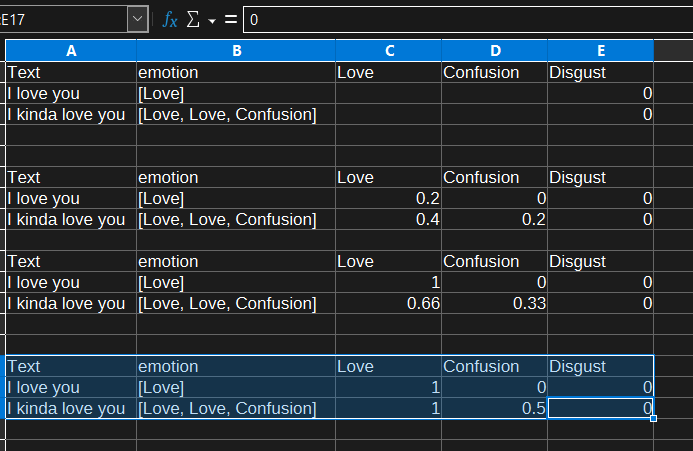

1. Based on rater number: more rater == more confidence on the prediction
  - While intuitive, the downside is that even comments that are clearly an emotion might get low confidence because a low amount of raters rated them
2. Based on emotion classification percentage
  - This assumes that there's a prevelant emotion for a comment, with the main objective of only predicting one emotion per comment, instead of possible emotions.
  - This also means that the less ambiguous emotion comments also have a higher confidence on the motion it is
  - Additionally, it gives more confidence to less raters
3. Based on emotion classificaiton count
  - This assumes that comments can be more than one emotion, and everytime a rater gives an emotion it ads to that confidence proportionally to the amount of raters
  - This also gives more confidence to less raters

We ultimately decided on approach 3

In [ ]:
library(purrr)
library(tibble)

group_raters <- function(df) {
  df %>% 
    group_by(id) %>% 
    summarise(
      text = first(text),
      n_raters = n(),
      emotions = list(emotions),
      author = first(author),
      subreddit = first(subreddit),
      link_id = first(link_id),
      parent_id = first(parent_id),
      created_utc = first(created_utc) %>% as.POSIXct(created_utc, origin = "1970-01-01", tz = "UTC"),
      across(starts_with("emotion_"), sum)
    ) %>% 
    mutate(across(starts_with("emotion_"), ~ ./n_raters))
} 

df_3g  <- df_3 %>% group_raters()
df_6g  <- df_6 %>% group_raters()
df_28g <- df_28 %>% group_raters()
df_3g %>% print

# A tibble: 58,011 × 12
   id      text             n_raters emotions author subreddit link_id parent_id
   <chr>   <chr>               <int> <list>   <chr>  <chr>     <chr>   <chr>    
 1 eczazk6 "Fast as [NAME]…        2 <list>   Uptow… NewOrlea… t3_abb… t1_eczav…
 2 eczb07q "You blew it. T…        2 <list>   ima_c… self      t3_abc… t3_abca3b
 3 eczb4bm "TL;DR No more …        3 <list>   socia… steelers  t3_ab8… t3_ab8t8l
 4 eczb527 "So much time s…        3 <list>   Touri… Roadcam   t3_aba… t3_abal7g
 5 eczb6r7 "Emotes have a …        5 <list>   Reggi… Blackops4 t3_aba… t1_ecz9n…
 6 eczb770 "Just life.. I …        4 <list>   itsuh… depressi… t3_abc… t1_ecz72…
 7 eczbbmd "Thanks for the…        3 <list>   hyper… dxm       t3_ab5… t1_ecz71…
 8 eczbbwt "*they were not…        5 <list>   LadyK… AskWomen  t3_ab9… t1_ecz9q…
 9 eczbdg4 "Glad to hear i…        3 <list>   Jehos… raisedby… t3_ab5… t1_ecz8c…
10 eczbe89 "To be fair you…        5 <list>   Unida… 4PanelCr… t3_ab6… t1_ecyu2…
# ℹ 

# Remove less than 3 raters

they are not a lot and it gives us more confidence and other nuances

In [ ]:
df_3gf  <- df_3g %>% filter(n_raters >= 3)
df_6gf  <- df_6g %>% filter(n_raters >= 3)
df_28gf <- df_28g %>% filter(n_raters >= 3)
df_3gf %>% print

# A tibble: 57,349 × 12
   id      text             n_raters emotions author subreddit link_id parent_id
   <chr>   <chr>               <int> <list>   <chr>  <chr>     <chr>   <chr>    
 1 eczb4bm "TL;DR No more …        3 <list>   socia… steelers  t3_ab8… t3_ab8t8l
 2 eczb527 "So much time s…        3 <list>   Touri… Roadcam   t3_aba… t3_abal7g
 3 eczb6r7 "Emotes have a …        5 <list>   Reggi… Blackops4 t3_aba… t1_ecz9n…
 4 eczb770 "Just life.. I …        4 <list>   itsuh… depressi… t3_abc… t1_ecz72…
 5 eczbbmd "Thanks for the…        3 <list>   hyper… dxm       t3_ab5… t1_ecz71…
 6 eczbbwt "*they were not…        5 <list>   LadyK… AskWomen  t3_ab9… t1_ecz9q…
 7 eczbdg4 "Glad to hear i…        3 <list>   Jehos… raisedby… t3_ab5… t1_ecz8c…
 8 eczbe89 "To be fair you…        5 <list>   Unida… 4PanelCr… t3_ab6… t1_ecyu2…
 9 eczbfxj "Now this is po…        3 <list>   voltr… CFB       t3_aba… t3_abaia3
10 eczbh7y "I was AF enlis…        3 <list>   pullb… Military  t3_ab8… t1_ecz76…
# ℹ 

# Write parquets

In [7]:
# write to disk
df_3gf %>% 
  write_parquet(
    here("data", "goemotions_3.parquet"),
    compression = "snappy"
  )
df_6gf %>%
  write_parquet(
    here("data", "goemotions_6.parquet"),
    compression = "snappy"
  )
df_28gf %>%
  write_parquet(
    here("data", "goemotions_28.parquet"),
    compression = "snappy"
  )